# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Finding** 
***

## Camera Calibration

In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import os
import errno
import glob

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

objpoints = []
imgpoints = []

# Read calibration images from 'camera_cal/' folder
images = glob.glob('./camera_cal/calibration*.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(10)

cv2.destroyAllWindows()

def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[:2],None,None)
    undist = cv2.undistort(img, mtx, dist, None, None)
    return ret, mtx, dist, rvecs, tvecs, undist

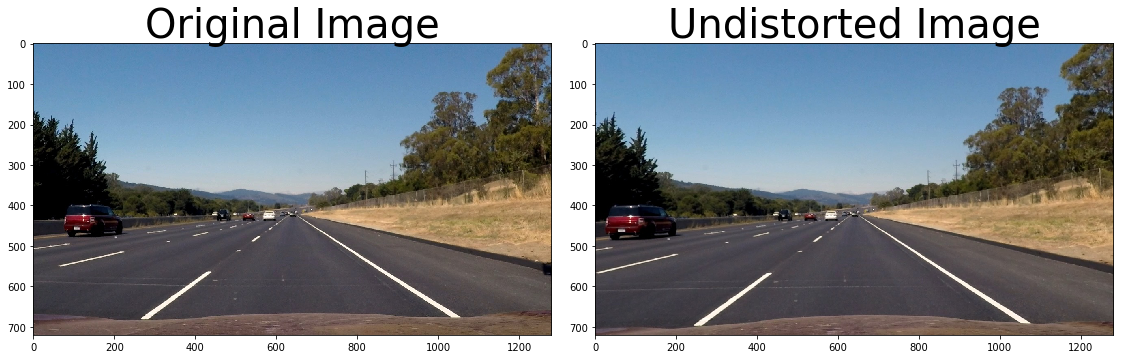

In [2]:
%matplotlib inline
#img = cv2.imread('./camera_cal/calibration1.jpg')
img = cv2.imread('./test_images/straight_lines2.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
ret, mtx, dist, rvecs, tvecs, undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)

## Lane Detection Pipeline

In [3]:
def filter(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    #yellow filter
    lower_threshold = np.array([10, 150, 100]) 
    upper_threshold = np.array([50, 255, 255]) 
    mask = cv2.inRange(hsv, lower_threshold, upper_threshold)
    
    #white filter
    lower_threshold = np.array([0, 100, 200]) 
    upper_threshold = np.array([150, 255, 255]) 
    mask = cv2.inRange(hsv, lower_threshold, upper_threshold)
    #convt = cv2.addWeighted(img, 1,cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB), 1, 0)
    return mask

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, [vertices], ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def pipeline(img, s_thresh=(200, 255), sx_thresh=(40, 80)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float32)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x gradient
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    l_thresh=(200,255)
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))*1 # for image test
#    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))*255 # for video processing

    # Filter from project1
    gray = filter(img)
    #gray = cv2.cvtColor(filtered, cv2.COLOR_RGB2GRAY)
    #adapt = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,7,1)
    
    binary = np.zeros_like(sxbinary)
    binary[((l_binary ==1) | (gray > 120)) | ((sxbinary==1)&(s_binary==1)) |
           ((img[:,:,0]>120)&(img[:,:,1] >100)&(img[:,:,2]<100))] = 1
#    (sxbinary == 1) 
    return binary


## Image Threshold

test_images_output/frame1044.jpg
test_images_output/frame1045.jpg
test_images_output/frame1046.jpg
test_images_output/frame1047.jpg
test_images_output/frame611.jpg
test_images_output/straight_lines1.jpg
test_images_output/straight_lines2.jpg
test_images_output/test1.jpg
test_images_output/test2.jpg
test_images_output/test3.jpg
test_images_output/test4.jpg
test_images_output/test5.jpg
test_images_output/test6.jpg


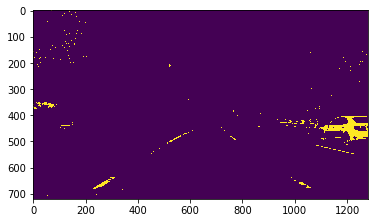

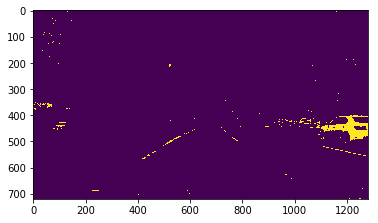

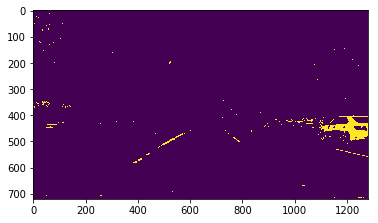

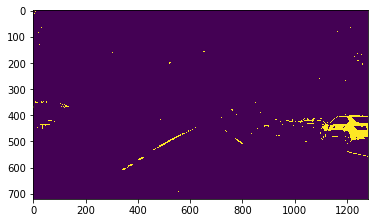

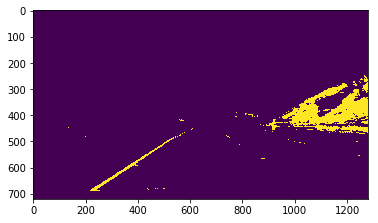

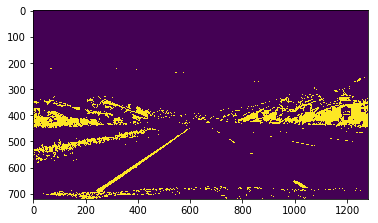

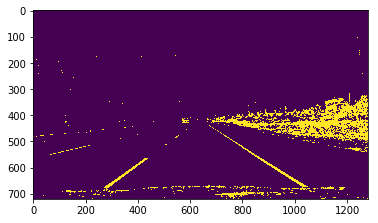

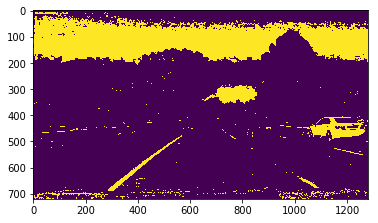

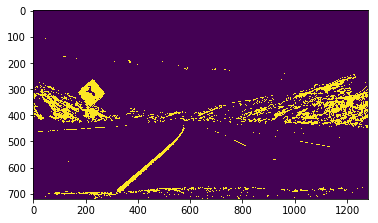

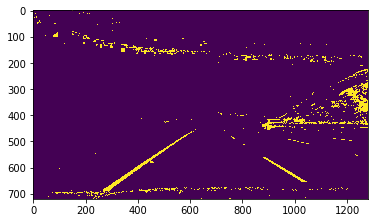

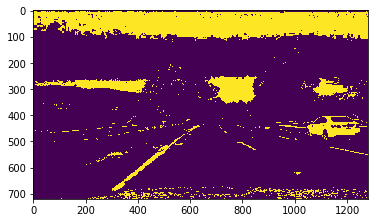

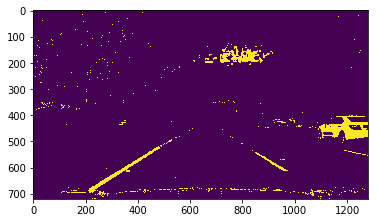

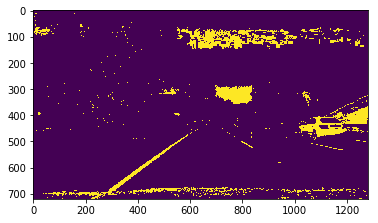

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import errno
%matplotlib inline

from moviepy.editor import VideoFileClip
from IPython.display import HTML

def save_image():
#    print(os.getcwd())
    test_dir = 'test_images/'
    output_dir = 'test_images_output/'

    files = os.listdir(test_dir)

    for file in files:  
        image = mpimg.imread(test_dir + file)
        output = pipeline(image)
        filename = output_dir + file
        
        os.makedirs(os.path.dirname(filename), exist_ok=True)

        print(filename)
        fig = plt.figure()
        plt.imshow(output)

save_image()

## Distortion correction & Perspective Transform

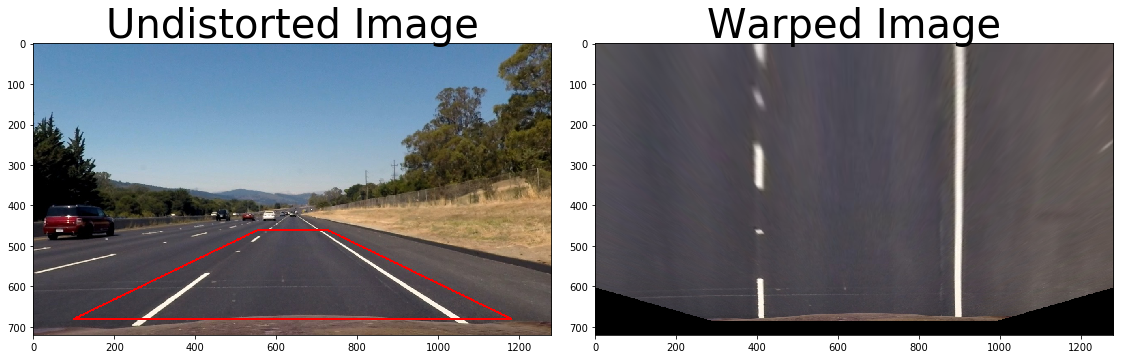

In [5]:
img = cv2.imread('./test_images/straight_lines2.jpg')
undist = cv2.undistort(img, mtx, dist, None, None)

def transform(img, nx, ny):
#    global mtx, dist
#    undist = cv2.undistort(img, mtx, dist, None, None)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    
    imshape = img.shape
    x1 = int(imshape[1]/2 - 85)
    x2 = int(imshape[1]/2 + 85)
    y1 = int(imshape[0]/2 + 100)
    y2 = int(imshape[0])

    if img is not None:
        src = np.float32([[100,y2-40],[x1, y1],[x2, y1],[imshape[1]-100,y2-40]])
        dst = np.float32([[300,670],[300,50],[980,50],[980,670]])

        M = cv2.getPerspectiveTransform(src, dst)
        img_size = (gray.shape[1], gray.shape[0])
        transformed = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)

    return transformed, M, src, dst

transformed, perspective_M, src, dst = transform(undist, nx=9, ny=6)
copy_undist = undist
copy_transf = transformed

imshape = img.shape
x1 = int(imshape[1]/2 - 85)
x2 = int(imshape[1]/2 + 85)
y1 = int(imshape[0]/2 + 100)
y2 = int(imshape[0])

src_pts = np.array([[100,y2-40],[x1, y1],[x2, y1],[imshape[1]-100,y2-40]], np.int32)
#src_pts = pts.reshape((-1,1,2))
cv2.polylines(copy_undist,[src_pts],True,(0,0,255), thickness=3)

dst_pts = np.array([[300,670],[300,50],[980,50],[980,670]], np.int32)
#dst_pts = dst.reshape((-1,1,2))
#cv2.polylines(copy_transf,[dst_pts],True,(0,0,255), thickness=3)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(copy_undist, cv2.COLOR_BGR2RGB))
ax1.set_title('Undistorted Image', fontsize=40)
ax2.imshow(cv2.cvtColor(copy_transf, cv2.COLOR_BGR2RGB))
ax2.set_title('Warped Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Curvature Calculation

(720, 1280) uint8


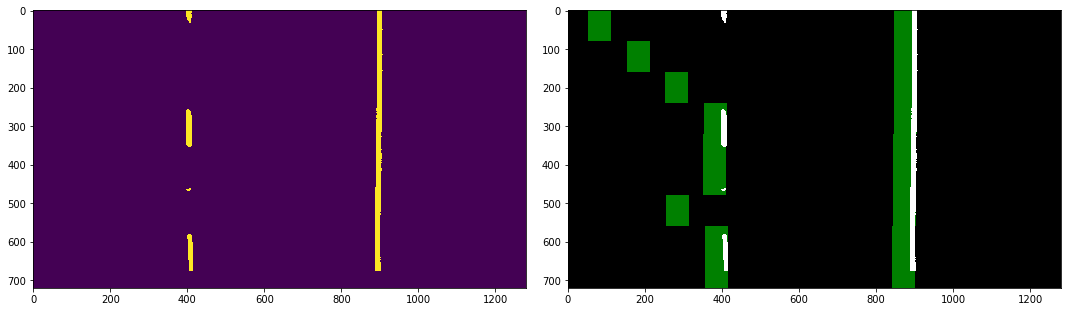

In [6]:
#warped = mpimg.imread('warped_example.jpg')

warped = pipeline(transformed)
print(warped.shape, warped.dtype)

window_width = 60 
window_height = 80
margin = 100

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = []
    window = np.ones(window_width)
    
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    window_centroids.append((l_center,r_center))
    
    for level in range(1,(int)(image.shape[0]/window_height)):
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

if len(window_centroids) > 0:

    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    for level in range(0,len(window_centroids)):
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    template = np.array(r_points+l_points,np.uint8)
    zero_channel = np.zeros_like(template)
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8)
    warpage= np.dstack((warped, warped, warped))*255
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0)

else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9))
f.tight_layout()
ax1.imshow(warped)
ax2.imshow(output)


(720, 1280)


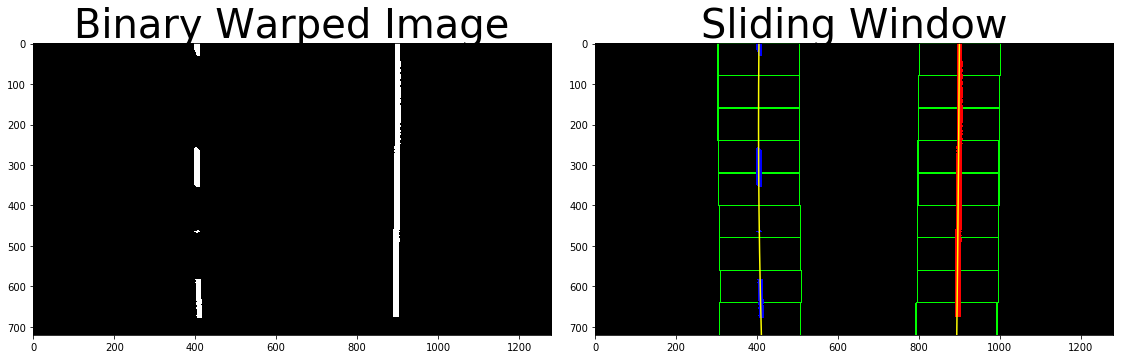

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

#binary_warped = pipeline(warped)
binary_warped = warped
w = binary_warped
#binary_warped = w.astype(int)
print(w.shape)

b=np.int(binary_warped.shape[0]/2)
histogram = np.sum(binary_warped[b:,:], axis=0)
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

nwindows = 9
window_height = np.int(binary_warped.shape[0]/nwindows)
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

leftx_current = leftx_base
rightx_current = rightx_base

margin = 100
minpix = 50

left_lane_inds = []
right_lane_inds = []

for window in range(nwindows):
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)

    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9))
f.tight_layout()
ax1.imshow(w, cmap = 'gray')
ax1.set_title('Binary Warped Image', fontsize=40)
ax2.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
ax2.set_title('Sliding Window', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

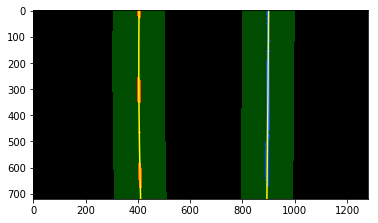

In [8]:
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

19425.09 m 119624.69 m
6139.46 m 37840.54 m


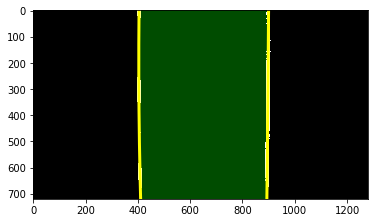

In [9]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print("%.2f m" %left_curverad, "%.2f m" %right_curverad)

ym_per_pix = 30/620 # values adjusted
xm_per_pix = 3.7/500 # meters per pixel in x dimension

left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

print("%.2f m" %left_curverad, "%.2f m" %right_curverad)

plt.plot(left_fitx, ploty, color='yellow', linewidth=3)
plt.plot(right_fitx, ploty, color='yellow', linewidth=3)
plt.gca().invert_yaxis()

out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
road_lane = np.hstack((left_line, right_line))
road_lane_img = np.zeros_like(out_img)
cv2.fillPoly(road_lane_img, np.int_([road_lane]), (0, 255, 0))
weighted = cv2.addWeighted(out_img, 1, road_lane_img, 0.3, 0)
plt.imshow(weighted)

In [12]:
#left_fit_prev=left_fit
#right_fit_prev=right_fit
def lane_coloring(img):
    global objpoints, imgpoints, src, dst, mtx, dist
    
    # Video frame undistort
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[:2],None,None)
    undist = cv2.undistort(img, mtx, dist, None, None)

    # Perspective transform
    if img is not None:
        M = cv2.getPerspectiveTransform(src, dst)
        img_size = (undist.shape[1], undist.shape[0])
        transformed = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
        
    # Binary image creation from thresholding pipeline
    binary_warped = pipeline(transformed)
    
    # Masking from Project1
    vertices = np.array([[250,670],[250,50],[1030,50],[1030,670]], np.int32)
    binary_warped = region_of_interest(binary_warped, vertices)
        
    # Sliding window
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    b=np.int(binary_warped.shape[0]/2)
    histogram = np.sum(binary_warped[b:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base
    rightx_current = rightx_base

    margin = 100
    minpix = 50

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Lane curvature calculation       
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
#    if np.all(lefty is True) and np.all(righty is True): 
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left_fit_prev=left_fit
    right_fit_prev=right_fit
#    else:
#        left_fit=left_fit_prev
#        right_fit=right_fit_prev
        
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    y_eval = np.max(ploty)
    ym_per_pix = 30/620
    xm_per_pix = 3.7/500    

    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Lane coloring
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    road_lane = np.hstack((left_line, right_line))
    road_lane_img = np.zeros_like(out_img)
    cv2.fillPoly(road_lane_img, np.int_([road_lane]), (0, 255, 0))
    weighted = cv2.addWeighted(out_img, 1, road_lane_img, 0.3, 0)

    # Position Calculation    
    yvalue = img.shape[0]
    left_p = left_fit[0]*yvalue**2 + left_fit[1]*yvalue + left_fit[2]
    right_p = right_fit[0]*yvalue**2 + right_fit[1]*yvalue + right_fit[2]
    ctr_p = (left_p + right_p)/2

    direction = ''
    if ctr_p - 640 > 0:
        direction = 'Left '
    elif ctr_p - 640 < 0:
        direction = 'Right '
    elif ctr_p - 640 == 0:
        direction = 'Centered '

    rad = (left_curverad + right_curverad)/2
    dist = abs((ctr_p - 640)*xm_per_pix)

    # Put text on image or a frame of video
    font = cv2.FONT_HERSHEY_DUPLEX
    text = direction + '{:04.2f}'.format(dist) + 'm' + ' from center'
    cv2.putText(undist, text, (50,80), font, 1.2, (100,255,100), thickness=3)

    text = 'Avg. Curve Rad: ' + '{:0.2f}'.format(rad) + 'm'
    cv2.putText(undist, text, (50,120), font, 1.2, (100,255,100), thickness=3)

    # Unwarp to transform coloring back to camera perspective
    M1 = cv2.getPerspectiveTransform(dst, src)
    unwarp = cv2.warpPerspective(weighted, M1, img_size, flags=cv2.INTER_LINEAR)
    #undist = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB) #Uncomment for images
    colored = cv2.addWeighted(undist, 1, unwarp, 0.6, 0)
    return colored

In [13]:
# Testing lane_coloring() on images
test_dir = './test_images/'
output_dir = './test_images_output/'
files = os.listdir(test_dir)

for file in files:
    image = mpimg.imread(test_dir + file)
    output = lane_coloring(image)
    filename = output_dir + file

    os.makedirs(os.path.dirname(filename), exist_ok=True)
    cv2.imwrite(filename, output)

In [14]:
#run following commands to download ffmpeg
#import imageio
#imageio.plugins.ffmpeg.download()

from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

output = 'test_videos_output/project_output.mp4'

clip = VideoFileClip("project_video.mp4")#.subclip(41,42)
processed_clip = clip.fl_image(lane_coloring)

os.makedirs(os.path.dirname(output), exist_ok=True)
%time processed_clip.write_videofile(output, audio=False)
processed_clip.reader.close()
processed_clip.audio.reader.close_proc()
print("done")
HTML("""
<video width="480" height="270" controls>
  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video test_videos_output/project_output.mp4
[MoviePy] Writing video test_videos_output/project_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [35:27<00:01,  1.43s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_output.mp4 

Wall time: 35min 29s
done


In [14]:
output = 'test_videos_output/challenge_output.mp4'

clip = VideoFileClip("challenge_video.mp4")#.subclip(0,4)
processed_clip = clip.fl_image(lane_coloring)

os.makedirs(os.path.dirname(output), exist_ok=True)
%time processed_clip.write_videofile(output, audio=False)
processed_clip.reader.close()
processed_clip.audio.reader.close_proc()
print("done")
HTML("""
<video width="480" height="270" controls>
  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video test_videos_output/challenge_output.mp4
[MoviePy] Writing video test_videos_output/challenge_output.mp4


 27%|█████████████████████▊                                                          | 132/485 [04:27<09:15,  1.57s/it]

TypeError: expected non-empty vector for x

done


In [15]:
output = 'test_videos_output/harder_challenge_output.mp4'

clip = VideoFileClip("harder_challenge_video.mp4")#.subclip(0,5)
processed_clip = clip.fl_image(lane_coloring)

os.makedirs(os.path.dirname(output), exist_ok=True)
%time processed_clip.write_videofile(output, audio=False)
processed_clip.reader.close()
processed_clip.audio.reader.close_proc()
print("done")
HTML("""
<video width="480" height="270" controls>
  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video test_videos_output/harder_challenge_output.mp4
[MoviePy] Writing video test_videos_output/harder_challenge_output.mp4



  3%|██▌                                                                             | 38/1200 [01:00<28:36,  1.48s/it]


KeyboardInterrupt: 

done


In [ ]:
# This code is to capture video frame. Only for testing purpose.
vidcap = cv2.VideoCapture("./project_video.mp4")
success,image = vidcap.read()
count = 0
success = True
while success:
  success,image = vidcap.read()
  cv2.imwrite("./video_frame/frame%d.jpg" % count, image)
  if cv2.waitKey(10) == 27:
      break
  count += 1
